GBDT and Random Forest are machine learning algorithm that can be used to predict polarity of reviews in amazon fine foods dataset obtained from kaggle. (https://www.kaggle.com/snap/amazon-fine-food-reviews) 

In this ipython notebook,following steps are performed:
    1. Load cleaned data 
    2. Sample data
    3. Convert text to vector using one of the following methods
        a.bag of words
        b.tf-idf
        c.average word2vec
        d.tf-idf word2vec
    4. Use GBDT and Random Forest to predict polarity
    5. Performance measurement
        a. accuracy
        b. confusion matrix
        c. presicion, recall and f1-score

1. Load cleaned Data

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


#Using sqlite3 to retrieve data from sqlite file
con = sqlite3.connect(r'C:\Users\Admin\Downloads\final.sqlite')

#Read data from the sqlite file
data = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)


2.Randomly sample data

In [2]:
data.sort_values('Time',inplace=True,ascending=False)
sampled_data=data[:12000]

In [3]:
#We use 70% of data for training and 30% of data for test
import math
sampled_data.sort_values('Time',inplace=True,ascending=True) 

X_train =  sampled_data[:math.ceil(len(sampled_data)*.7)] 
X_test = sampled_data[math.ceil(len(sampled_data)*.3):]
y_train = sampled_data['Score'][:math.ceil(len(sampled_data)*.7)]
y_test =  sampled_data['Score'][math.ceil(len(sampled_data)*.3):]

3.Convert to vector

Bag of Words

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer() 
bow_model = count_vect.fit(X_train['CleanedText'])
final_bow_train = bow_model.transform(X_train['CleanedText'])
final_bow_test = bow_model.transform(X_test['CleanedText'])

Find optimal alpha and gamma

Grid Search

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
base_ln = [x for x in range(1, 21)]
learning_rate = [x/10 for x in range(1,11)]
depth = [x for x in range(1,6)]
xgb = XGBClassifier(booster='gbtree', )
paramgrid = {'n_estimators': base_ln, 'learning_rate': learning_rate, 'max_depth': depth}
grid = GridSearchCV(estimator = xgb,param_grid=paramgrid ,cv = 3,n_jobs = 3)
grid.fit(final_bow_train, y_train)
print("best depth = ", grid.best_params_)
optimal_depth= grid.best_params_

best depth =  {'learning_rate': 0.7, 'max_depth': 5, 'n_estimators': 19}


In [6]:
classifier = XGBClassifier(booster='gbtree',max_depth=optimal_depth.get('max_depth'),learning_rate=optimal_depth.get('learning_rate'),n_estimators=optimal_depth.get('n_estimators'))

In [7]:
classifier.fit(final_bow_train,y_train)
predicted = classifier.predict(final_bow_test)

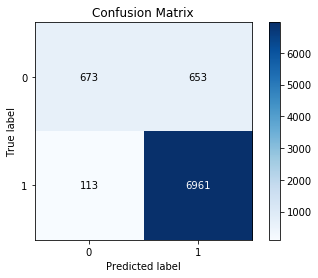

In [8]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_test ,predicted)

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [10]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 90.881%
Precision on test set: 0.914
Recall on test set: 0.984
F1-Score on test set: 0.948


Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
base_ln = [x for x in range(1, 21)]
depth = [x for x in range(1,6)]
param={'n_estimators': base_ln, 'max_depth': depth}
grid = GridSearchCV(estimator = rfc,param_grid=param ,cv = 3,n_jobs = 3)
grid.fit(final_bow_train, y_train)
print("best depth = ", grid.best_params_)
optimal_depth = grid.best_params_

best depth =  {'max_depth': 1, 'n_estimators': 1}


In [12]:
classifier = RandomForestClassifier(max_depth=optimal_depth.get('max_depth'),n_estimators=optimal_depth.get('n_estimators'))

In [13]:
classifier.fit(final_bow_train,y_train)
predicted = classifier.predict(final_bow_test)

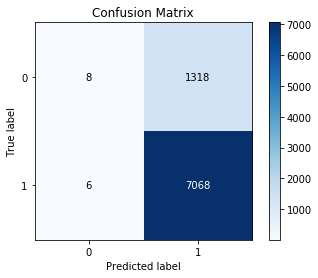

In [14]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_test ,predicted)

In [15]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 84.238%
Precision on test set: 0.843
Recall on test set: 0.999
F1-Score on test set: 0.914


TF-IDF 

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vec = TfidfVectorizer()
tfidf_model = tf_idf_vec.fit(X_train['CleanedText'])
final_tfidf_train = tfidf_model.transform(X_train['CleanedText'])
final_tfidf_test = tfidf_model.transform(X_test['CleanedText'])

In [17]:
from sklearn.preprocessing import StandardScaler
normalised_tfidf_train = StandardScaler(with_mean=False).fit_transform(final_tfidf_train)
normalised_tfidf_test = StandardScaler(with_mean=False).fit_transform(final_tfidf_test)

In [18]:
base_ln = [x for x in range(1, 21)]
learning_rate = [x/10 for x in range(1,11)]
depth = [x for x in range(1,6)]
xgb = XGBClassifier(booster='gbtree', )
paramgrid = {'n_estimators': base_ln, 'learning_rate': learning_rate, 'max_depth': depth}
grid = GridSearchCV(estimator = xgb,param_grid=paramgrid ,cv = 3,n_jobs = 3)
grid.fit(normalised_tfidf_train, y_train)
print("best depth = ", grid.best_params_)
optimal_depth= grid.best_params_

best depth =  {'learning_rate': 0.6, 'max_depth': 5, 'n_estimators': 17}


In [19]:
classifier = XGBClassifier(booster='gbtree',max_depth=optimal_depth.get('max_depth'),learning_rate=optimal_depth.get('learning_rate'),n_estimators=optimal_depth.get('n_estimators'))
classifier.fit(normalised_tfidf_train,y_train)
predicted = classifier.predict(normalised_tfidf_test)

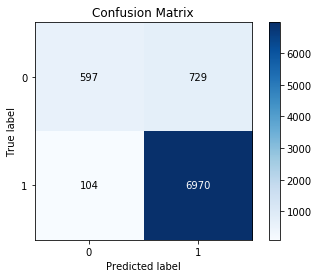

In [20]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [21]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 90.083%
Precision on test set: 0.905
Recall on test set: 0.985
F1-Score on test set: 0.944


In [22]:
base_ln = [x for x in range(1, 21)]
depth = [x for x in range(1,6)]
param={'n_estimators': base_ln, 'max_depth': depth}
grid = GridSearchCV(estimator = rfc,param_grid=param ,cv = 3,n_jobs = 3)
grid.fit(normalised_tfidf_test, y_train)
print("best depth = ", grid.best_params_)
optimal_depth = grid.best_params_

best depth =  {'max_depth': 1, 'n_estimators': 3}


In [23]:
classifier = RandomForestClassifier(max_depth=optimal_depth.get('max_depth'),n_estimators=optimal_depth.get('n_estimators'))
classifier.fit(normalised_tfidf_train,y_train)
predicted = classifier.predict(normalised_tfidf_test)

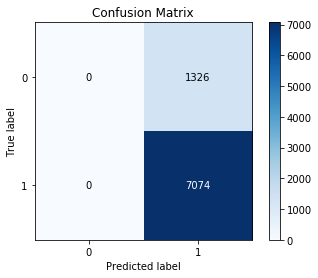

In [24]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [25]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 84.214%
Precision on test set: 0.842
Recall on test set: 1.000
F1-Score on test set: 0.914


Average word2vec

In [26]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim

In [27]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
import nltk
from nltk.corpus import stopwords

stop = set(stopwords.words('english')) #set of stopwords
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [28]:
i=0
str1=''
list_of_sent_train=[]
final_string_for_tfidf_train = []
for sent in X_train['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
  
    list_of_sent_train.append(filtered_sentence)
    final_string_for_tfidf_train.append((str1).strip())

In [29]:
i=0
str1=''
list_of_sent=[]
final_string_for_tfidf = []
for sent in sampled_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
  
    list_of_sent.append(filtered_sentence)
    final_string_for_tfidf.append((str1).strip())

In [30]:
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=2)

In [31]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [32]:
X_train = sent_vectors[:math.ceil(len(sampled_data)*.7)]  #final_w2v_count
X_test = sent_vectors[math.ceil(len(sampled_data)*.3):] #final_w2v_count

In [33]:
X_train=np.nan_to_num(X_train)
X_test=np.nan_to_num(X_test)

In [34]:
normalised_w2v_train = StandardScaler(with_mean=False).fit_transform(X_train)
normalised_w2v_test = StandardScaler(with_mean=False).fit_transform(X_test)

In [35]:
grid = GridSearchCV(estimator = xgb,param_grid=paramgrid ,cv = 3,n_jobs = 3)
grid.fit(np.array(normalised_w2v_train), y_train)
print("best depth = ", grid.best_params_)
optimal_depth= grid.best_params_

best depth =  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 20}


In [36]:
classifier = XGBClassifier(booster='gbtree',max_depth=optimal_depth.get('max_depth'),learning_rate=optimal_depth.get('learning_rate'),n_estimators=optimal_depth.get('n_estimators'))
classifier.fit(normalised_w2v_train,y_train)

predicted = classifier.predict(normalised_w2v_test)

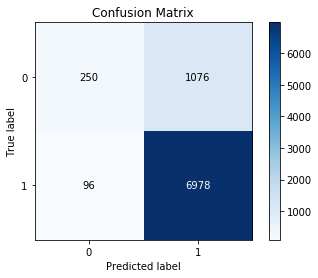

In [37]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [38]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 86.048%
Precision on test set: 0.866
Recall on test set: 0.986
F1-Score on test set: 0.923


In [39]:
from sklearn.model_selection import RandomizedSearchCV
rand = RandomizedSearchCV(estimator = xgb,param_distributions=paramgrid ,cv = 4,n_jobs = 3)
rand.fit(normalised_w2v_train, y_train)
optimal_alpha = rand.best_params_
print("best alpha = ", optimal_alpha)

best alpha =  {'n_estimators': 11, 'max_depth': 5, 'learning_rate': 0.3}


In [40]:
classifier = XGBClassifier(booster='gbtree',max_depth=optimal_alpha.get('max_depth'),learning_rate=optimal_alpha.get('learning_rate'),n_estimators=optimal_alpha.get('n_estimators'))
classifier.fit(normalised_w2v_train,y_train)

predicted = classifier.predict(normalised_w2v_test)

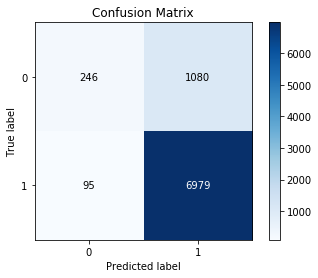

In [41]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [42]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 86.012%
Precision on test set: 0.866
Recall on test set: 0.987
F1-Score on test set: 0.922


In [43]:
grid = GridSearchCV(estimator = rfc,param_grid=param ,cv = 3,n_jobs = 3)
grid.fit(normalised_w2v_train, y_train)
print("best depth = ", grid.best_params_)
optimal_depth = grid.best_params_

best depth =  {'max_depth': 5, 'n_estimators': 9}


In [44]:
classifier = RandomForestClassifier(max_depth=optimal_depth.get('max_depth'),n_estimators=optimal_depth.get('n_estimators'))
classifier.fit(normalised_w2v_train,y_train)
predicted = classifier.predict(normalised_w2v_test)

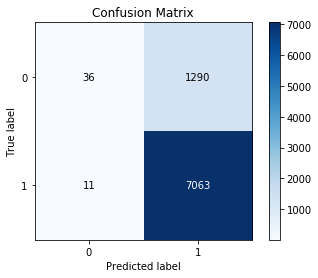

In [45]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [46]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 84.512%
Precision on test set: 0.846
Recall on test set: 0.998
F1-Score on test set: 0.916


TF-IDF Avg w2v

In [47]:
tf_idf_w2v = TfidfVectorizer()
tfidf_model = tf_idf_w2v.fit(final_string_for_tfidf_train)
final_tfidf_w=tfidf_model.transform(final_string_for_tfidf)

In [48]:
tfidf_feat = tf_idf_w2v.get_feature_names()


tfidf_sent_vectors = [];
row=0;
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf_w[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except Exception as e: 
            pass #print(e)
            
    try:
        sent_vec /= weight_sum
    except:
        print(e)
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [49]:
X_train = tfidf_sent_vectors[:math.ceil(len(sampled_data)*.7)]  #final_w2v_count
X_test = tfidf_sent_vectors[math.ceil(len(sampled_data)*.3):] #final_w2v_count

In [50]:
X_train=np.nan_to_num(X_train)
X_test=np.nan_to_num(X_test)

In [51]:
normalised_tfidf_train = StandardScaler(with_mean=False).fit_transform(X_train)
normalised_tfidf_test = StandardScaler(with_mean=False).fit_transform(X_test)

In [52]:
grid = GridSearchCV(estimator = xgb,param_grid=paramgrid ,cv = 3,n_jobs = 3)
grid.fit(np.array(normalised_w2v_train), y_train)
print("best depth = ", grid.best_params_)
optimal_depth= grid.best_params_

best depth =  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 20}


In [53]:
classifier = XGBClassifier(booster='gbtree',max_depth=optimal_depth.get('max_depth'),learning_rate=optimal_depth.get('learning_rate'),n_estimators=optimal_depth.get('n_estimators'))

classifier.fit(normalised_tfidf_train,y_train)

predicted = classifier.predict(normalised_tfidf_test)

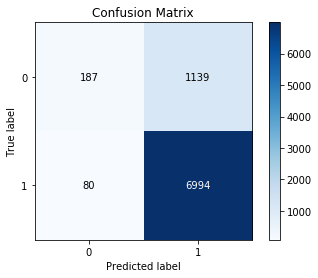

In [54]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [55]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 85.488%
Precision on test set: 0.860
Recall on test set: 0.989
F1-Score on test set: 0.920


In [56]:
rand = RandomizedSearchCV(estimator = xgb,param_distributions=paramgrid ,cv = 4,n_jobs = 3)
rand.fit(normalised_tfidf_train, y_train)
optimal_alpha = rand.best_params_
print("best alpha = ", optimal_alpha)

best alpha =  {'n_estimators': 19, 'max_depth': 1, 'learning_rate': 0.6}


In [57]:
classifier = XGBClassifier(booster='gbtree',max_depth=optimal_alpha.get('max_depth'),learning_rate=optimal_alpha.get('learning_rate'),n_estimators=optimal_alpha.get('n_estimators'))

classifier.fit(normalised_tfidf_train,y_train)

predicted = classifier.predict(normalised_tfidf_test)

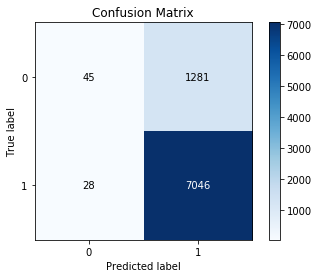

In [58]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [59]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 84.417%
Precision on test set: 0.846
Recall on test set: 0.996
F1-Score on test set: 0.915


In [60]:
grid = GridSearchCV(estimator = rfc,param_grid=param ,cv = 3,n_jobs = 3)
grid.fit(normalised_tfidf_train, y_train)
print("best depth = ", grid.best_params_)
optimal_depth = grid.best_params_

best depth =  {'max_depth': 5, 'n_estimators': 8}


In [61]:
classifier = RandomForestClassifier(max_depth=optimal_depth.get('max_depth'),n_estimators=optimal_depth.get('n_estimators'))
classifier.fit(normalised_tfidf_train,y_train)
predicted = classifier.predict(normalised_tfidf_test)

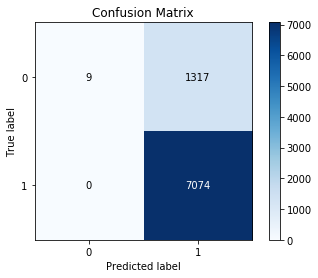

In [62]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [63]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 84.321%
Precision on test set: 0.843
Recall on test set: 1.000
F1-Score on test set: 0.915
